
## Seoul City taxi request forecast

------------

<b>[ Objective ]</b>

- We want predict the future taxi-demand within 30-min of all locations.

![motivation](./output_file/graph/goal_setting.png)

<br>


<b>[ Summary ]</b>

- TGNet(temporal guided network) applied Seoul City & NYC taxi datasets.
- It outperforms previous models. 
- Research Paper - accepted NIPS 2018 workshop [(link)](https://openreview.net/pdf?id=BygF00DuiX)

<br>

<b>[ Intro ]</b>

- On-demand taxi request service is very convenient in city life.
- Taxi request data shows variety pattern depends on the time and location

<br>

![SEO_data_stats](./output_file/graph/seo_data_stats.png)
```
Seoul Ride Hailing Requests:
(left) the ride hailing requests in residential and commercial area,
(middle) different patterns in residential area on holiday and
(right) average requests in each day of week
```

<br>

<b>[ Data Processing ]</b>

- To capture the Spatial / Temporal information in the same time
- We use Unet based the fully convolutional network
- To do this, we split the Seoul city to 50x50 grid (approx. 800m x 700m ) and the data aggregated in 30 mins.
- We used the Requests data on the spot and drop-off data on the spot.
- Two data type have different patterns, below shows the results.



<br>
<b>[ Results ]</b>

- We applied the TGNet model to Seoul City datasets.


| Method | MAPE | RMSE |
|:--------|:--------:|:--------:|
| ARIMA | 23.05% | 12.53 |
| XGBoost | 19.68% | 8.08 |
| Baseline | 18.87% | 7.06 |
| Baseline + Drop-off | 18.62% | 6.73 |
| Baseline + Temporal Information | 17.97% | 6.68 |
| <b>TGNet</b> | <b>17.72</b> | <b>6.32</b> |



<br><br><br>
<b>[ Contribution ]</b>

- Our contribution is introduced temporal data directly to model output, then increase the performance.
- Another one is using drop-off data. In some locations, drop-off data may represent the future demand.
- We located those spot that held festival, concert and events irregularly.

![Event_spots](./output_file/graph/event_graph.png)

```
- We select 4 Area which has stadium or complex hall
- That place held the event irregularly such as Concert, Festival, Convention
  - (1) Gocheok Skydome [37.498555, 126.867300]
  - (2) Jangchung Sports Complex [37.558160, 127.006782]
  - (3) Seoul worldcup stadium - (Sangam) [37.568130, 126.897210]
  - (4) Seoul olympic stadium - (Jamsil) [37.515686, 127.072793]
```



# (1) Data Preparation 

In [1]:

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

from data_utils import*

import matplotlib.pyplot as plt
%matplotlib inline

## Original Taxi Data
 - more than 1M data daily 

In [2]:

df_csv = pd.read_csv('/data/project/rw/kakao_dataset_csv/20170223.csv')
print (df_csv.shape)
df_csv.head()

(864444, 47)


,Unnamed: 0,passenger_id,driver_id,taxi_id,taxi_kind,parent_call_id,status,origin_name,origin_type,origin_name1,origin_name2,origin_name3,destination_name,destination_type,destination_name1,destination_name2,destination_name3,passenger_name1,passenger_name2,passenger_name3,return_taxi,retry_count,referrer,dispatch_status,distance_to_start,seconds_to_start,distance_to_end,seconds_to_end,business_type,created_at,dispatched_at,pickup_at,dropoff_at,origin_x,origin_y,destination_x,destination_y,passenger_x,passenger_y,taxi_x,taxi_y,pickup_x,pickup_y,dropoff_x,dropoff_y,origin_confirmid,destination_confirmid
0,0,+2Z74TjpX66vzTTqldT17Q==,\N,\N,medium,\N,70,강남역 2호선 11번출구,PLACE,서울특별시,강남구,역삼1동,가락고등학교,PLACE,서울특별시,송파구,송파2동,\N,\N,\N,0,1,\N,30,\N,\N,10281,1159,\N,20170223005941,20170223010039,\N,\N,"127.027466881,202428.811013","37.4987688776,444367.83926199999","127.11741790799999,210382.5","37.501679474299998,444697.00000100001","0,0","0,0","0,0","0,0",\N,\N,\N,\N,\N,\N
1,1,rgaSUQKMizfM2kLXM8UH9g==,176700,270837,medium,\N,50,청원경찰서,PLACE,충청북도,청주시 청원구,우암동,MBC 충북,PLACE,충청북도,청주시 흥덕구,가경동,충청북도,청주시 청원구,우암동,0,0,\N,10,267,77,6886,911,1,20170223054502,20170223054514,20170223054648,20170223060234,"127.485305129,243394.75","36.650728711699998,350362.50000200002","127.43486283999999,238900.275077","36.6189478943,346814.106616","127.4856856,243428.19744799999","36.651750100000001,350476.01787099999","127.4877274,243611.08940600001","36.651181700000002,350413.86703999998","127.48529859999999,243394.262001","36.650557999999997,350343.55278600001","127.4342894,238849.05478400001","36.618795300000002,346796.94092600001",\N,\N
2,2,kdR5jWv5k9B0TeKh8pXqCQ==,84473,370325,medium,\N,50,GS25 화곡봉제산점,PLACE,서울특별시,강서구,화곡8동,현대백화점 목동점,PLACE,서울특별시,양천구,목1동,서울특별시,강서구,화곡본동,0,1,\N,10,481,166,3949,1077,0,20170223092528,20170223092535,20170223092843,20170223093959,"126.850067139,186748.70643399999","37.537258148200003,448649.87177000003","126.875354544,188982","37.526063358899997,447404.12500100001","126.84861650000001,186620.879705","37.539401699999999,448887.98540000001","126.8462892,186414.436013","37.535217099999997,448423.879342","126.8502605,186765.80568699999","37.537312900000003,448655.921325","126.8740275,188864.84660799999","37.527074800000001,447516.53869800002",\N,\N
3,3,96k73WFpaDf6lpy5r/twXQ==,\N,\N,medium,\N,60,401레스토랑,PLACE,서울특별시,마포구,서교동,발산역 5호선 1번출구,PLACE,서울특별시,강서구,가양1동,서울특별시,마포구,서교동,0,0,\N,\N,\N,\N,\N,\N,\N,20170223003223,\N,\N,\N,"126.920590159,192982.89906200001","37.550697047299998,450133.826397","126.83753244,185645.02771900001","37.558935652700001,451057.65605200001","126.920252033,192953.025226","37.550748931299999,450139.61018999998",\N,\N,\N,\N,\N,\N,\N,\N
4,4,YAv/3FRD4rxVgzaNOfcsUg==,237302,575378,medium,\N,50,공덕삼성래미안2차아파트 108동,PLACE,서울특별시,마포구,공덕동,KBS연구관앞주차장,PLACE,서울특별시,영등포구,여의동,서울특별시,마포구,공덕동,0,0,\N,10,282,59,6170,859,1,20170223095554,20170223095559,20170223100045,20170223101322,"126.95990770900001,196457.22771800001","37.550870074000002,450150.82206899999","126.91543579099999,192525.05688300001","37.526920318599998,447495.29682300001","126.9592286,196397.244125","37.551413699999998,450211.18384999997","126.9626564,196700.14724200001","37.551556699999999,450226.92929200002","126.95952560000001,196423.45127600001","37.550635399999997,450124.79054399999","126.9153972,192521.637812","37.526841500000003,447486.552004",\N,\N


## Data preperation before making numpy 

In [3]:
data_csv = pd.read_csv('./data/data_2017_selected.csv')
data_csv.head()

,Unnamed: 0,year,month,day,hour,minute,start_x,start_y,end_x,end_y
0,0,2017,1.0,1.0,21.0,41.0,126.901143,37.574250,126.904912,37.562310
1,1,2017,1.0,1.0,21.0,12.0,126.917085,37.481712,126.899039,37.485608
2,2,2017,1.0,1.0,18.0,19.0,127.005671,37.599246,124.848488,33.474969
3,3,2017,1.0,1.0,7.0,33.0,127.038195,37.524708,127.023412,37.567072
4,4,2017,1.0,1.0,7.0,10.0,127.025147,37.604080,127.073415,37.660624


## Making Numpy data frome the table 
- select the data within boundary 


#### Seoul City boundary 
```
bound_left = 126.764467 
bound_right = 127.183756
bound_top = 37.701454
bound_bottom = 37.428415
```

#### Data aggregation 
```
50 x 50 grid within in 30min 
```

#### Start & End (destination) data size 
```
( total days to train * 24 * ( 60 / 30 ) )  x 50 x 50

```

In [4]:
st_data = load_np_data('./data/np_start_data.npz')
ed_data = load_np_data('./data/np_end_data.npz')
print (st_data.max(), ed_data.max())
print (st_data.shape, ed_data.shape)

./data/np_start_data.npz Loaded
./data/np_end_data.npz Loaded
4491.0 6128.0
(8688, 50, 50) (8688, 50, 50)


## Data visualization 

Text(0.5, 1.0, 'End : 08h')

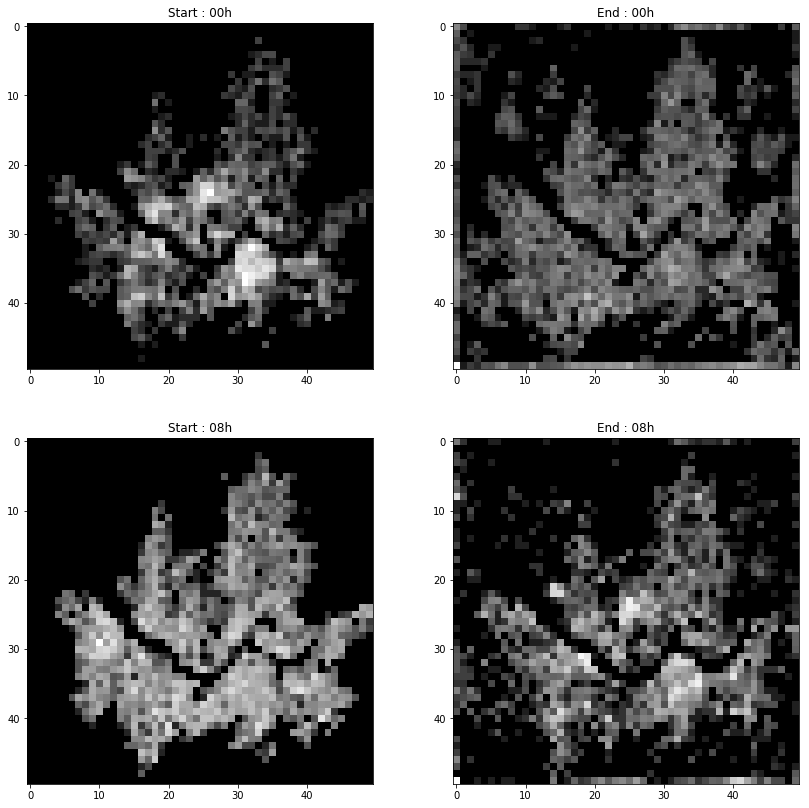

In [5]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14, 14))
idx = 480
ax1.imshow(np.log(st_data[idx, :, :]+1),  cmap='gray')
ax1.set_title("Start : 00h")
idx = 480
ax2.imshow(np.log(ed_data[idx, :, :]+1),  cmap='gray')
ax2.set_title("End : 00h")

idx = 496
ax3.imshow(np.log(st_data[idx, :, :]+1),  cmap='gray')
ax3.set_title("Start : 08h")
idx = 496
ax4.imshow(np.log(ed_data[idx, :, :]+1),  cmap='gray')
ax4.set_title("End : 08h")


# (2) Model Training 

------------

<b>[ Overview ]</b>

- Model Preview.

![objectives](./output_file/graph/tgnet_preview.png)


In [6]:

################################################################################
## Import Module
################################################################################

from utils import *
import os

import tensorflow as tf
import keras
import keras.backend as K

from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, Flatten, Reshape, Dropout, Conv2DTranspose
from keras.layers import Concatenate, BatchNormalization, Add
from keras.models import Model, Sequential
from keras.layers import InputLayer
from keras.utils.training_utils import multi_gpu_model



Using TensorFlow backend.


In [7]:
################################################################################
## Hyperparam  - args = parser.parse_args()
################################################################################

LRATE = 1e-2 # [ 1e-5, 1e-4, 1e-3, 5e-2, 1e-2, 1e-1 ]
BATCH_SIZE = 128 # [ 512, 256, 128, 64 ]
EPOCHS = 3000
SCALE = 'log' # or 'max' or 'log'
NGPU = 4
NPTS = 100 # early stopping patience iteration

## Folder / File Name
DATA_FOLDER = '/data/public/rw/prj-mobility/datasets/2018_ori/'

## Baseline Model Folder 
BASE_MODEL_NAME = 'BASE_MODEL'
MODEL_VER = '1201_baseline_2ch_base_v1_end_bn_ba128'

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [8]:
################################################################################
## Working Directory Setting 
################################################################################

OUTPUT_FOLDER = '../output_file/'
TF_FOLDER = '../tfgraph/'
MODEL_SAVE_FOLDER = '../saved_model/'

MODEL_NAME_ = BASE_MODEL_NAME+'_'+MODEL_VER
OUTPUT_FOLDER = OUTPUT_FOLDER+BASE_MODEL_NAME+'/'
TF_FOLDER = TF_FOLDER+BASE_MODEL_NAME+'/'+MODEL_VER
MODEL_SAVE_FOLDER = MODEL_SAVE_FOLDER+BASE_MODEL_NAME+'/'

print ('Model Name :',MODEL_NAME_)

if os.path.isdir(OUTPUT_FOLDER) == False:
    os.makedirs(OUTPUT_FOLDER)
    print ('Output Folder :',OUTPUT_FOLDER, 'created')
else :
    print ('Output Folder :',OUTPUT_FOLDER)

if os.path.isdir(TF_FOLDER) == False:
    os.makedirs(TF_FOLDER)
    print ('Tfgraph Folder :',TF_FOLDER, 'created')
else :
    print ('Tfgraph Folder :',TF_FOLDER)
    
if os.path.isdir(MODEL_SAVE_FOLDER) == False:
    os.makedirs(MODEL_SAVE_FOLDER)
    print ('Save Folder :',MODEL_SAVE_FOLDER, 'created')
else :
    print ('Save Folder :',MODEL_SAVE_FOLDER)

Model Name : BASE_MODEL_1201_baseline_2ch_base_v1_end_bn_ba128
Output Folder : ../output_file/BASE_MODEL/
Tfgraph Folder : ../tfgraph/BASE_MODEL/1201_baseline_2ch_base_v1_end_bn_ba128
Save Folder : ../saved_model/BASE_MODEL/


In [9]:
################################################################################
## Data Load
################################################################################
## Train period = 2018/01/01 ~ 2018/04/30 ( 80% / 20% validation split)
## Test period = 2018/05/01 ~ 2018/06/30 

x_st_train = load_np_data(DATA_FOLDER+'X_train_data_st_30min_16ch_ori.npz')
x_ed_train = load_np_data(DATA_FOLDER+'X_train_data_ed_30min_16ch_ori.npz')
y_train = load_np_data(DATA_FOLDER+'Y_train_data_st_30min_16ch_ori.npz')
x_week_train = load_np_data(DATA_FOLDER+'week_train_data_30min_16ch_ori.npz')
x_time_train = load_np_data(DATA_FOLDER+'time_train_data_30min_16ch_ori.npz')
x_holi_train = load_np_data(DATA_FOLDER+'holi_train_data_30min_16ch_ori.npz')
x_prev_train = load_np_data(DATA_FOLDER+'prev_train_data_30min_16ch_ori.npz')

x_st_test = load_np_data(DATA_FOLDER+'X_test_data_st_30min_16ch_ori.npz')
x_ed_test = load_np_data(DATA_FOLDER+'X_test_data_ed_30min_16ch_ori.npz')
y_test = load_np_data(DATA_FOLDER+'Y_test_data_st_30min_16ch_ori.npz')
x_week_test = load_np_data(DATA_FOLDER+'week_test_data_30min_16ch_ori.npz')
x_time_test = load_np_data(DATA_FOLDER+'time_test_data_30min_16ch_ori.npz')
x_holi_test = load_np_data(DATA_FOLDER+'holi_test_data_30min_16ch_ori.npz')
x_prev_test = load_np_data(DATA_FOLDER+'prev_test_data_30min_16ch_ori.npz')

print (x_st_train.max(), x_ed_train.max())


### Data normalization in logscale 

x_st_train = logscale(x_st_train) 
x_ed_train = logscale(x_ed_train)
y_train = logscale(y_train)

x_st_test = logscale(x_st_test)
x_ed_test = logscale(x_ed_test)
y_test = logscale(y_test)

x_temporal_train = make_temporal_concat(x_week_train, x_time_train, x_holi_train, x_prev_train)
x_temporal_test = make_temporal_concat(x_week_test, x_time_test, x_holi_test, x_prev_test)

### Train / Valid Split
train_data_size = int(len(x_st_train)*0.8)
x_st_valid = x_st_train[train_data_size:]
x_ed_valid = x_ed_train[train_data_size:]
y_valid = y_train[train_data_size:]
x_temporal_valid = x_temporal_train[train_data_size:]

x_st_train = x_st_train[:train_data_size]
x_ed_train = x_ed_train[:train_data_size]
y_train = y_train[:train_data_size]
x_temporal_train = x_temporal_train[:train_data_size]

/data/public/rw/prj-mobility/datasets/2018_ori/X_train_data_st_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobility/datasets/2018_ori/X_train_data_ed_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobility/datasets/2018_ori/Y_train_data_st_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobility/datasets/2018_ori/week_train_data_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobility/datasets/2018_ori/time_train_data_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobility/datasets/2018_ori/holi_train_data_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobility/datasets/2018_ori/prev_train_data_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobility/datasets/2018_ori/X_test_data_st_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobility/datasets/2018_ori/X_test_data_ed_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobility/datasets/2018_ori/Y_test_data_st_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobility/datasets/2018_ori/week_test_data_30min_16ch_ori.npz Loaded
/data/public/rw/prj-mobil

In [15]:
################################################################################
## Model
################################################################################

K.clear_session()
print ('Session Reseted')

model_input_train_data = [x_st_train, x_ed_train, x_temporal_train]
model_input_valid_data = [x_st_valid, x_ed_valid, x_temporal_valid]
model_input_test_data = [x_st_test, x_ed_test, x_temporal_test]

def make_temporal_model(st_data, ed_data, tmp_data):

        im_h,im_w,im_c = st_data[0].shape
        
        start_input = Input(shape=(st_data[0].shape))
        end_input = Input(shape=(ed_data[0].shape))
        temporal_input = Input(shape=(tmp_data[0].shape))
        
        input_tensors = [start_input, end_input, temporal_input]
        
        ## Coord input has x-y coord in integer number 
        coord_input = keras.layers.Lambda(lambda xin: xin[:,:,:,-2:] )(start_input)
        start_input = keras.layers.Lambda(lambda xin: xin[:,:,:,:-2] )(start_input)
    
        # Conv2D default Parameters 
        # - use_bias=True 
        # - kernel_initializer='glorot_uniform' 
        #  ( Xavier uniform initializer , range +/- sqrt(6 / (input_unit + output_unit)) )
        # - bias_initializer='zeros'

        ## Temporal Data Embedding 
        net_temp = Conv2D(16, kernel_size=(1,1), strides=(1,1))(temporal_input)
        net_temp = Conv2D(16, kernel_size=(1,1), strides=(1,1))(net_temp)
        # outlayer Shape - [ 50 x 50 x 16 ]
        
        ## Embedded Temporal data concat 
        net1 = layers.concatenate([start_input, net_temp], axis=-1)

        net1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=None, padding='valid')(net1)
        net1 = layers.Activation('relu')(net1)
        net1 = BatchNormalization()(net1)
        # outlayer Shape - [ 48 x 48 x 64 ]
        
        ## Skip connection Layer
        net11 = AveragePooling2D(pool_size=(4,4), strides=4)(net1)
        # outlayer Shape - [ 12 x 12 x 64 ]

        # Dense Block Start 
        net2 = Conv2D(256, kernel_size=(3,3), strides=(1,1), activation=None, padding='same')(net11)
        net2 = layers.Activation('relu')(net2)
        net2 = BatchNormalization()(net2)
        # outlayer Shape - [ 12 x 12 x 256 ]
        
        net3 = Conv2D(256, kernel_size=(3,3), strides=(1,1), activation=None, padding='same')(net2)
        net3 = layers.Activation('relu')(net3)
        net3 = BatchNormalization()(net3)
        # outlayer Shape - [ 12 x 12 x 256 ]
        
        ## Skip connection Layer
        net33 = layers.concatenate([net2, net3], axis=-1)
        
        net4 = Conv2D(256, kernel_size=(3,3), strides=(1,1), activation=None, padding='same')(net33)
        net4 = layers.Activation('relu')(net4)
        net4 = BatchNormalization()(net4)
        # outlayer Shape - [ 12 x 12 x 256 ]
        
        ## Skip connection Layer
        net44 = layers.concatenate([net2, net3, net4], axis=-1)

        ## Upsampling Layer 
        net5 = Conv2DTranspose(256, kernel_size=(4,4), strides=(4,4), padding='same')(net44)
        net5 = layers.Activation('relu')(net5)
        net5 = BatchNormalization()(net5)
        net5 = Dropout(0.5)(net5)
        # outlayer Shape - [ 48 x 48 x 256 ]
        
        ## Skip connection Layer
        net55 = layers.concatenate([net5, net1], axis=-1)

        net6 = Conv2DTranspose(512, kernel_size=(3,3), strides=(1,1), padding='valid')(net55)
        net6 = layers.Activation('relu')(net6)
        net6 = BatchNormalization()(net6)
        net6 = Dropout(0.5)(net6)
        # outlayer Shape - [ 50 x 50 x 512 ]
        
        # End point data Embedding Layer 
        net_end = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(end_input)
        net_end = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(net_end)
        # outlayer Shape - [ 50 x 50 x 64 ]
        
        net7 = layers.concatenate([net6, start_input, net_end, end_input, net_temp, coord_input], axis=-1)
        net7 = Conv2DTranspose(512, kernel_size=(1,1), strides=(1,1), padding='same')(net7)
        net7 = layers.Activation('relu')(net7)
        net7 = BatchNormalization()(net7)
        # outlayer Shape - [ 50 x 50 x 512 ]

        output = Conv2D(1, kernel_size=(1,1), strides=(1,1), padding='same')(net7)
        output = layers.Activation('relu')(output)
        # outlayer Shape - [ 50 x 50 x 1 ]

        model = Model(inputs=input_tensors, outputs=output)
        return model

b_model = make_temporal_model(x_st_train,x_ed_train, x_temporal_train)
model = multi_gpu_model(b_model, gpus=NGPU)
print (MODEL_NAME_, 'Model Created')
print (b_model.summary())


Session Reseted
BASE_MODEL_1201_baseline_2ch_base_v1_end_bn_ba128 Model Created
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 50, 59)   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 50, 50, 10)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 16)   960         input_3[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 50, 50, 8)    0           input_1[0][0]                    
_____________________________

In [16]:

################################################################################
## Callback 
################################################################################


from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

from keras.callbacks import Callback

class SGDLearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr) # K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        print('LR: {:.6f}'.format(lr))

tb_hist = keras.callbacks.TensorBoard(log_dir=TF_FOLDER, histogram_freq=0, write_graph=True, write_images=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=NPTS, verbose=0, mode='min')






In [18]:
################################################################################
## Training  
################################################################################

EPOCHS=5

import time
start_time = time.time() 


model.compile(loss=['mse'], optimizer=Adam(lr=LRATE,  decay=0.01), metrics=['mae', invlog_rmse, invlog_mape])
    
history = model.fit(model_input_train_data , y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  callbacks=[tb_hist, early_stopping, SGDLearningRateTracker()],
                  shuffle = True,
                  verbose=1
                  ,validation_data=(model_input_valid_data, y_valid)
                 )

val_loss = history.history['val_loss']
val_metric = history.history['val_invlog_mape']

history_save(val_loss, val_metric, model_name =  MODEL_NAME_+'step_1', output_folder=OUTPUT_FOLDER)

#model.compile(loss=['mae'], optimizer=Adam(lr=LRATE,  decay=0.01), metrics=['mae', invlog_rmse, invlog_mape])

#history = model.fit(model_input_train_data , y_train,
#                  batch_size=BATCH_SIZE,
#                  epochs=EPOCHS,
#                  callbacks=[tb_hist, early_stopping, SGDLearningRateTracker()],
#                  shuffle = False,
#                  verbose=1
#                  ,validation_data=(model_input_valid_data, y_valid)
#                 )
    
#val_loss = history.history['val_loss']
#val_metric = history.history['val_invlog_mape']

end_time = time.time()
n_epochs = len(val_metric)

print("--- Train Time : %0.2f hour  ---" %(  (end_time - start_time)/3600  ))
print("--- # of Epochs: %0.f  ---" %( n_epochs ) )



Train on 4595 samples, validate on 1149 samples
Epoch 1/5
4595/4595 [==============================] - 30s 7ms/step - loss: 0.5858 - mean_absolute_error: 0.3853 - invlog_rmse: 1293.7412 - invlog_mape: 1.2481 - val_loss: 4.2832 - val_mean_absolute_error: 1.3402 - val_invlog_rmse: 1986.6659 - val_invlog_mape: 13.9895
LR: 0.010000
Epoch 2/5
4595/4595 [==============================] - 25s 5ms/step - loss: 0.1732 - mean_absolute_error: 0.2191 - invlog_rmse: 10.9425 - invlog_mape: 0.2471 - val_loss: 0.3021 - val_mean_absolute_error: 0.3070 - val_invlog_rmse: 11.8417 - val_invlog_mape: 0.5313
LR: 0.010000
Epoch 3/5
4595/4595 [==============================] - 24s 5ms/step - loss: 0.1611 - mean_absolute_error: 0.2120 - invlog_rmse: 10.3322 - invlog_mape: 0.2380 - val_loss: 0.2873 - val_mean_absolute_error: 0.2930 - val_invlog_rmse: 11.3708 - val_invlog_mape: 0.4923
LR: 0.010000
Epoch 4/5
4595/4595 [==============================] - 24s 5ms/step - loss: 0.1600 - mean_absolute_error: 0.2123 - i

In [19]:

################################################################################
## Model & Output Save  
################################################################################

save_model_name = MODEL_SAVE_FOLDER+MODEL_NAME_+'st2.h5'
b_model.save(save_model_name)
print ('Model Saved', save_model_name)

history_save(val_loss, val_metric, model_name =  MODEL_NAME_+'step_2', output_folder=OUTPUT_FOLDER)
make_test_ouput(model, model_input_test_data , y_test, model_name=MODEL_NAME_, norm=SCALE, output_folder=OUTPUT_FOLDER)





Model Saved ../saved_model/BASE_MODEL/BASE_MODEL_1201_baseline_2ch_base_v1_end_bn_ba128st2.h5
../output_file/BASE_MODEL/BASE_MODEL_1201_baseline_2ch_base_v1_end_bn_ba128step_2_loss_metric_invmape_0.210.csv  Val loss Saved
Test True saved :  ../output_file/BASE_MODEL/BASE_MODEL_1201_baseline_2ch_base_v1_end_bn_ba128_gt.csv
Test Pred saved :  ../output_file/BASE_MODEL/BASE_MODEL_1201_baseline_2ch_base_v1_end_bn_ba128_pred.csv

